# Valuación de inmuebles en un sistema de búsqueda online - ECI 2018 - Navent

## Análisis exploratorio

El dataset son propiedades en `venta` en México entre `2012` y `2016`, valuadas en `pesos mexicanos`. El csv de train tiene `240K` filas y `22` columnas. El csv de test tiene `60K` filas (y 21 columnas). La columna a predecir es `precio`.

In [1]:
# Importamos librerías de análisis de datos
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('mode.chained_assignment', None) # Deshabilita SettingWithCopyWarning. Ojo.

In [7]:
df = pd.read_csv('Data/data_train.csv', index_col='id', parse_dates=['fecha'])

In [3]:
print(f"Shape: {df.shape}")
print(f"Columnas: {df.columns}")

Shape: (180000, 23)
Columnas: Index(['Unnamed: 0', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion',
       'ciudad', 'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')


In [4]:
df[(df.tipodepropiedad != 'Casa') & (df.tipodepropiedad != 'Casa en condominio') & (df.garages > 0)]

,Unnamed: 0,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
id,,,,,,,,,,,,,,,,,,,,,,,
141560,157317,venta departamento san pedro de los pinos,bonito departamento en 3er piso con elevador. ...,Apartamento,Revolución 526,Benito Juárez,Distrito Federal,20.00,3.00,1.00,2.00,93.00,nan,23567.00,nan,nan,2016-12-12,0.00,0.00,0.00,1.00,1.00,2650000.00
272352,26118,excelente departamento mariano escobedo,<p>edad del inmueble 6 a&ntilde;os</p>\r\n<p>s...,Apartamento,MARIANO ESCOBEDO 193,Miguel Hidalgo,Distrito Federal,6.00,3.00,3.00,2.00,116.00,nan,24597.00,19.44,-99.18,2013-12-11,1.00,1.00,0.00,1.00,1.00,3450000.00
92110,41769,NaN,departamento listo para habitar con 2 recàmara...,Apartamento,Jaleb Ed Xcaret,Cancún,Quintana Roo,8.00,2.00,1.00,1.00,85.00,nan,50003433.00,nan,nan,2012-05-26,0.00,0.00,0.00,1.00,1.00,1250000.00
57107,138104,departamento en venta 3 recamaras periferico y...,excelente departamento de lujo ubicado en una ...,Apartamento,La Luna,San Andrés Cholula,Puebla,0.00,3.00,2.00,3.00,135.00,155.00,79822.00,nan,nan,2016-11-08,0.00,1.00,0.00,1.00,1.00,2700000.00
47457,63999,pre venta de deptos en residencial venecia,preventa de departamentos \nresidencial veneci...,Apartamento,AZCAPOTZALCO,Azcapotzalco,Distrito Federal,nan,2.00,1.00,1.00,65.00,65.00,23408.00,nan,nan,2014-12-07,1.00,1.00,0.00,1.00,1.00,1650000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39278,224088,oficina en venta en supermanzana,"edificio de 2 plantas, con 6 oficinas, espacio...",Oficina comercial,SM 20,Cancún,Quintana Roo,7.00,nan,2.00,3.00,250.00,nan,50003433.00,nan,nan,2012-03-06,0.00,0.00,0.00,0.00,0.00,3000000.00
242985,85305,"departamentos en venta en cocoyoc, morelos.",si de verdad quieres pasar fines de semanas co...,Apartamento,SN,Yautepec,Morelos,0.00,2.00,1.00,2.00,66.00,66.00,66366.00,nan,nan,2016-12-05,1.00,0.00,1.00,1.00,1.00,942900.00
64082,199041,vendo bonito departamento remodelado,"vendo bonito departamento remodelado, cuenta c...",Apartamento,CALLE ORIENTAL,Coyoacán,Distrito Federal,20.00,3.00,1.00,1.00,82.00,82.00,23698.00,19.32,-99.11,2015-10-05,0.00,0.00,0.00,1.00,1.00,1580000.00


In [5]:
df = df.drop('Unnamed: 0', axis=1)

In [6]:
df.head()

,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
id,,,,,,,,,,,,,,,,,,,,,,
298880,remate ultimo precio no negociable casa en ven...,<p>casa en residencial palmaris.\n</p><p>\n</p...,Casa en condominio,CANCUN CENTRO,Cancún,Quintana Roo,nan,3.00,2.00,2.00,170.00,160.00,nan,21.11,-86.85,2016-04-15,0.00,0.00,0.00,0.00,0.00,1900000.00
87355,"casa 2 habs, 2 baños, sector miramar, col. pla...",excelente oportunidad para adquirir un patrimo...,Casa,Pleamar 38,Guaymas,Sonora,5.00,2.00,1.00,2.00,140.00,156.00,350390.00,27.92,-110.94,2016-12-21,0.00,0.00,0.00,1.00,1.00,1250000.00
141560,venta departamento san pedro de los pinos,bonito departamento en 3er piso con elevador. ...,Apartamento,Revolución 526,Benito Juárez,Distrito Federal,20.00,3.00,1.00,2.00,93.00,nan,23567.00,nan,nan,2016-12-12,0.00,0.00,0.00,1.00,1.00,2650000.00
63104,valle de hacienda,"casa con 1 baño, 3 recamaras, espacio para est...",Casa,"Estado de México, Cuautitlan Izcalli, Valle de...",Cuautitlán Izcalli,Edo. de México,5.00,3.00,1.00,1.00,113.00,85.00,56868.00,nan,nan,2016-07-13,0.00,0.00,0.00,0.00,0.00,1200000.00
260795,hermosa casa en coyoacan,hermosa casa que cuenta con 4 recamaras con cl...,Casa,Calle Santiago Valverde,Coyoacán,Distrito Federal,5.00,4.00,3.00,2.00,150.00,400.00,274529.00,nan,nan,2016-02-05,0.00,0.00,0.00,1.00,1.00,4100000.00


#### Tipos de propiedad

Total tipos de propiedad: 23


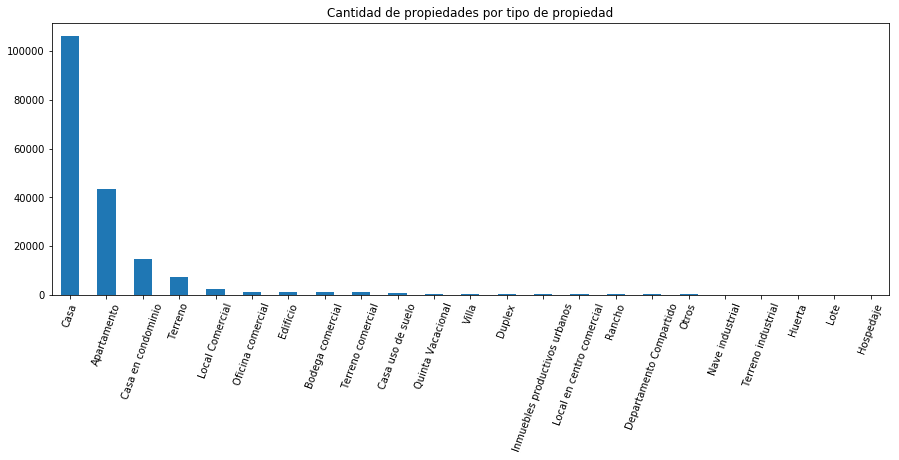

In [7]:
print(f"Total tipos de propiedad: {df.tipodepropiedad.nunique()}")
df.tipodepropiedad.value_counts().plot(kind='bar', figsize=(15, 5), rot=70, 
                                       title="Cantidad de propiedades por tipo de propiedad");

#### Propiedades por provincia

Total de provincias: 32


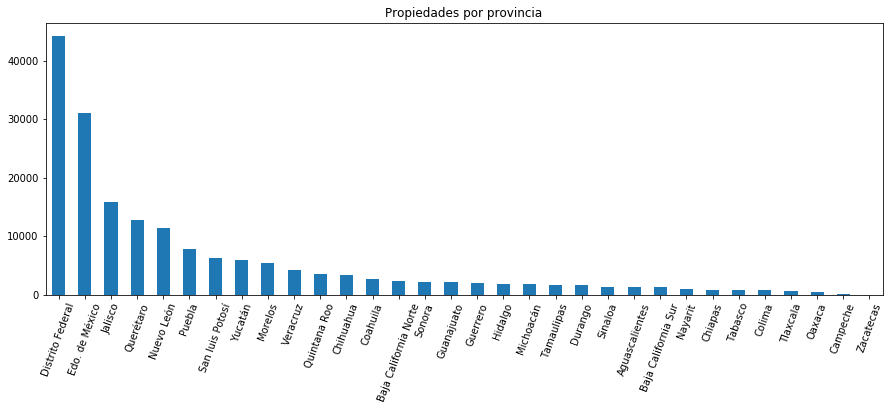

In [7]:
print(f"Total de provincias: {df.provincia.nunique()}")
df.provincia.value_counts().plot(kind='bar', figsize=(15, 5), rot=70, title="Propiedades por provincia");

#### Precio por provincia

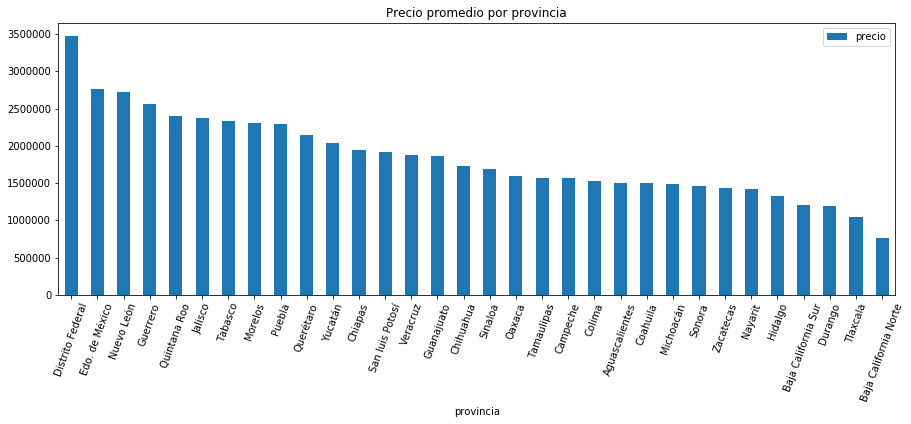

In [8]:
df.groupby('provincia').agg({'precio': 'mean'})\
    .sort_values('precio', ascending=False)\
    .plot(kind='bar', figsize=(15, 5), rot=70, title="Precio promedio por provincia");

#### Correlaciones

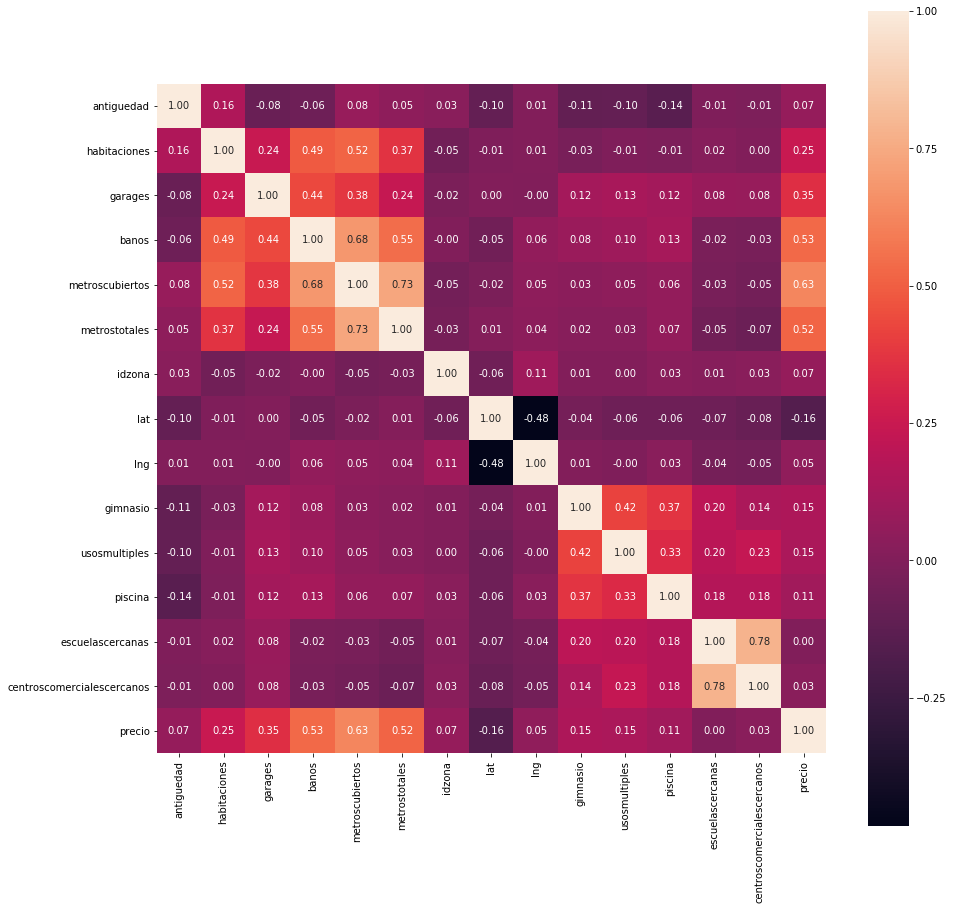

In [9]:
# Matriz de correlaciones como heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f');

In [9]:
df.piscina.unique()

array([0., 1.])

#### Datos faltantes

In [10]:
nulls = pd.DataFrame(df.isnull().sum().sort_values(), columns=['nulls'])
nulls['porcentaje'] = round(100*nulls['nulls'] / len(df), 2)
nulls

,nulls,porcentaje
precio,0,0.00
escuelascercanas,0,0.00
piscina,0,0.00
usosmultiples,0,0.00
gimnasio,0,0.00
fecha,0,0.00
centroscomercialescercanos,0,0.00
tipodepropiedad,32,0.02
provincia,112,0.06
ciudad,268,0.15


In [11]:
df.precio.describe()

count     180000.00
mean     2533124.79
std      2151137.95
min       310000.00
25%       960000.00
50%      1850000.00
75%      3400000.00
max     12525000.00
Name: precio, dtype: float64

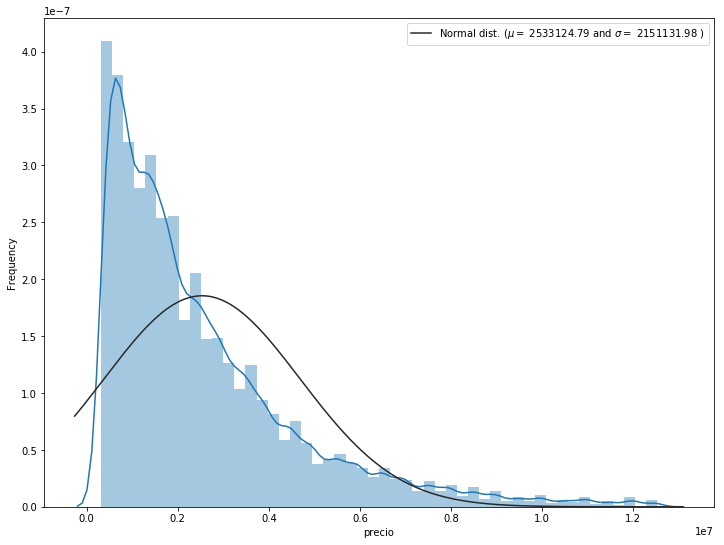

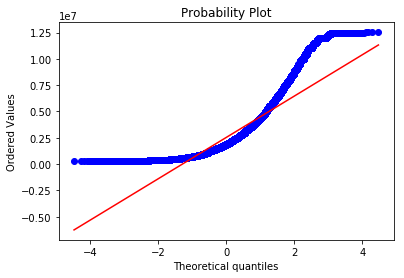

In [12]:
plt.subplots(figsize=(12,9))
sns.distplot(df['precio'], fit=stats.norm)

(mu, sigma) = stats.norm.fit(df['precio'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

fig = plt.figure()
stats.probplot(df['precio'], plot=plt)
plt.show()

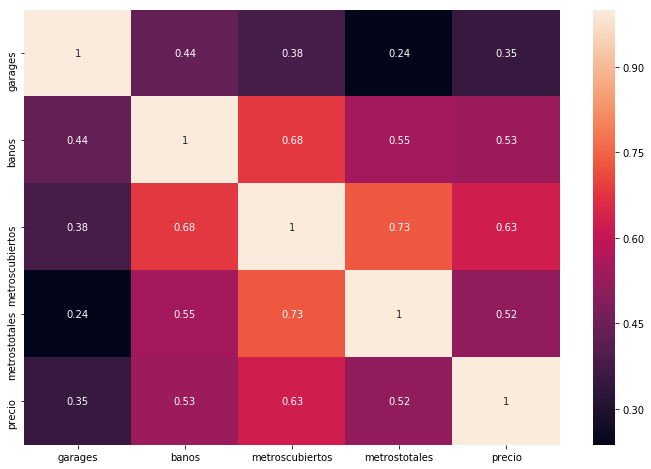

In [9]:
#Correlaciones con respecto al precio
corr = df.select_dtypes(include=[np.number]).corr()
top_feature = corr.index[abs(corr['precio']>0.3)]
plt.subplots(figsize=(12, 8))
top_corr = df[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

In [10]:
top_corr

,garages,banos,metroscubiertos,metrostotales,precio
garages,1.00,0.44,0.38,0.24,0.35
banos,0.44,1.00,0.68,0.55,0.53
metroscubiertos,0.38,0.68,1.00,0.73,0.63
metrostotales,0.24,0.55,0.73,1.00,0.52
precio,0.35,0.53,0.63,0.52,1.00


In [11]:
df.corr()

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,precio,comodidades_cercanas
antiguedad,1.00,0.16,-0.08,-0.06,0.08,0.05,0.03,-0.10,0.01,0.07,-0.08
habitaciones,0.16,1.00,0.24,0.49,0.52,0.37,-0.05,-0.01,0.01,0.25,-0.00
garages,-0.08,0.24,1.00,0.44,0.38,0.24,-0.02,0.00,-0.00,0.35,0.14
banos,-0.06,0.49,0.44,1.00,0.68,0.55,-0.00,-0.05,0.06,0.53,0.05
metroscubiertos,0.08,0.52,0.38,0.68,1.00,0.73,-0.05,-0.02,0.05,0.63,0.00
metrostotales,0.05,0.37,0.24,0.55,0.73,1.00,-0.03,0.01,0.04,0.52,-0.03
idzona,0.03,-0.05,-0.02,-0.00,-0.05,-0.03,1.00,-0.06,0.11,0.07,0.03
lat,-0.10,-0.01,0.00,-0.05,-0.02,0.01,-0.06,1.00,-0.48,-0.16,-0.10
lng,0.01,0.01,-0.00,0.06,0.05,0.04,0.11,-0.48,1.00,0.05,-0.03
precio,0.07,0.25,0.35,0.53,0.63,0.52,0.07,-0.16,0.05,1.00,0.10


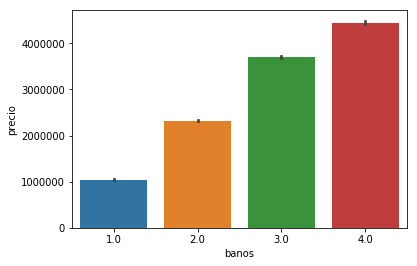

In [12]:
sns.barplot(df.banos, df.precio)

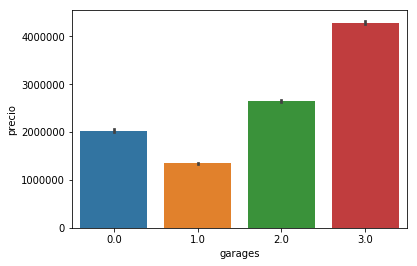

In [13]:
sns.barplot(df.garages, df.precio)

In [15]:
df[(df['garages']==1)].precio.mean()

1348368.027406177

In [16]:
df = df.drop(df[(df['garages']==0) & (df['precio']>1400000)].index).reset_index(drop=True)

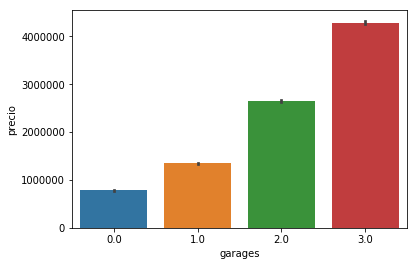

In [18]:
sns.barplot(df.garages, df.precio)

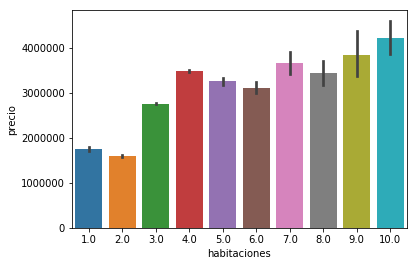

In [19]:
sns.barplot(df.habitaciones, df.precio)

<Figure size 1296x576 with 0 Axes>

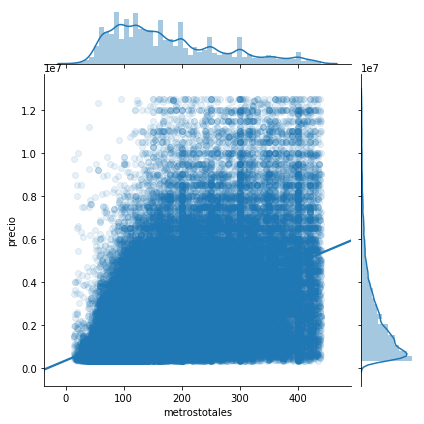

In [20]:
plt.figure(figsize=(18, 8))
sns.jointplot(x=df.metrostotales, y=df.precio, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.1)})

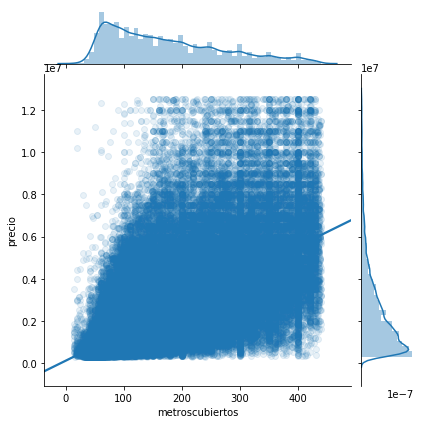

In [21]:
sns.jointplot(x=df.metroscubiertos, y=df.precio, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.1)})

In [22]:
print("Features mas importantes con respecto al precio")
corr = df.corr()
corr.sort_values(['precio'], ascending=False, inplace=True)
corr.precio

Features mas importantes con respecto al precio


precio                  1.00
metroscubiertos         0.64
banos                   0.54
metrostotales           0.52
garages                 0.49
habitaciones            0.25
comodidades_cercanas    0.11
antiguedad              0.07
idzona                  0.07
lng                     0.05
lat                    -0.16
Name: precio, dtype: float64

In [27]:
df.columns

Index(['titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'precio', 'comodidades_cercanas'],
      dtype='object')

In [23]:
del df['direccion']
del df['titulo']
del df['lng']
del df['lat']
del df['idzona']

In [24]:
del df['descripcion']

In [25]:
df.head()

,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,fecha,precio,comodidades_cercanas
0,Casa en condominio,Cancún,Quintana Roo,nan,3.00,2.00,2.00,170.00,160.00,2016-04-15,1900000.00,0.00
1,Casa,Guaymas,Sonora,5.00,2.00,1.00,2.00,140.00,156.00,2016-12-21,1250000.00,2.00
2,Apartamento,Benito Juárez,Distrito Federal,20.00,3.00,1.00,2.00,93.00,nan,2016-12-12,2650000.00,2.00
3,Casa,Cuautitlán Izcalli,Edo. de México,5.00,3.00,1.00,1.00,113.00,85.00,2016-07-13,1200000.00,0.00
4,Casa,Coyoacán,Distrito Federal,5.00,4.00,3.00,2.00,150.00,400.00,2016-02-05,4100000.00,2.00


#### Valores faltantes

In [26]:
df_prep = df.copy()

In [27]:
nulls = pd.DataFrame(df_prep.isnull().sum().sort_values(), columns=['nulls'])
nulls['porcentaje'] = round(100*nulls['nulls'] / len(df_prep), 2)
nulls[nulls.nulls > 0]

,nulls,porcentaje
tipodepropiedad,32,0.02
provincia,112,0.07
ciudad,261,0.15
metroscubiertos,11043,6.47
habitaciones,11736,6.88
banos,14744,8.64
garages,28539,16.72
antiguedad,30355,17.78
metrostotales,36286,21.26


#### Fechas

In [32]:
import datetime
df_prep['ano'] = df_prep.fecha.dt.year
df_prep=df_prep.drop('fecha',axis=1)

In [33]:
df_prep = df_prep.reset_index()
df_prep.head()

,index,tipodepropiedad,ciudad,provincia,habitaciones,garages,banos,metroscubiertos,metrostotales,precio,comodidades_cercanas,ano
0,0,Casa en condominio,Cancún,Quintana Roo,3.00,2.00,2.00,170.00,160.00,1900000.00,0.00,2016
1,1,Casa,Guaymas,Sonora,2.00,1.00,2.00,140.00,156.00,1250000.00,2.00,2016
2,2,Apartamento,Benito Juárez,Distrito Federal,3.00,1.00,2.00,93.00,nan,2650000.00,2.00,2016
3,3,Casa,Cuautitlán Izcalli,Edo. de México,3.00,1.00,1.00,113.00,85.00,1200000.00,0.00,2016
4,4,Casa,Coyoacán,Distrito Federal,4.00,3.00,2.00,150.00,400.00,4100000.00,2.00,2016


In [34]:
del df_prep['index']

In [35]:
df_prep.head(3)

,tipodepropiedad,ciudad,provincia,habitaciones,garages,banos,metroscubiertos,metrostotales,precio,comodidades_cercanas,ano
0,Casa en condominio,Cancún,Quintana Roo,3.00,2.00,2.00,170.00,160.00,1900000.00,0.00,2016
1,Casa,Guaymas,Sonora,2.00,1.00,2.00,140.00,156.00,1250000.00,2.00,2016
2,Apartamento,Benito Juárez,Distrito Federal,3.00,1.00,2.00,93.00,nan,2650000.00,2.00,2016


In [36]:
import category_encoders as ce 

In [37]:
ciudad_te = ce.TargetEncoder()
ciudad_te.fit(df_prep['ciudad'],df_prep['precio'])
df_prep['ciudad'] = ciudad_te.transform(df_prep['ciudad'])

In [38]:
provincia_te = ce.TargetEncoder()
provincia_te.fit(df_prep['provincia'],df_prep['precio'])
df_prep['provincia'] = provincia_te.transform(df_prep['provincia'])

In [39]:
tipo_te = ce.TargetEncoder()
tipo_te.fit(df_prep['tipodepropiedad'],df_prep['precio'])
df_prep['tipodepropiedad'] = tipo_te.transform(df_prep['tipodepropiedad'])

In [40]:
df_prep.corr()

,tipodepropiedad,ciudad,provincia,habitaciones,garages,banos,metroscubiertos,metrostotales,precio,comodidades_cercanas,ano
tipodepropiedad,1.00,0.22,0.28,-0.17,0.18,-0.07,-0.14,-0.18,0.17,0.10,-0.02
ciudad,0.22,1.00,0.58,0.00,0.21,0.23,0.21,0.19,0.55,0.11,0.03
provincia,0.28,0.58,1.00,-0.06,-0.00,-0.02,-0.03,-0.07,0.32,0.10,0.02
habitaciones,-0.17,0.00,-0.06,1.00,0.31,0.49,0.52,0.38,0.25,0.00,0.01
garages,0.18,0.21,-0.00,0.31,1.00,0.50,0.52,0.38,0.49,0.11,0.04
banos,-0.07,0.23,-0.02,0.49,0.50,1.00,0.69,0.55,0.54,0.05,0.06
metroscubiertos,-0.14,0.21,-0.03,0.52,0.52,0.69,1.00,0.74,0.64,0.01,0.03
metrostotales,-0.18,0.19,-0.07,0.38,0.38,0.55,0.74,1.00,0.52,-0.02,-0.01
precio,0.17,0.55,0.32,0.25,0.49,0.54,0.64,0.52,1.00,0.11,0.14
comodidades_cercanas,0.10,0.11,0.10,0.00,0.11,0.05,0.01,-0.02,0.11,1.00,-0.03


In [41]:
df_prep.isna().sum()

tipodepropiedad             0
ciudad                      0
provincia                   0
habitaciones            11736
garages                 28539
banos                   14744
metroscubiertos         11043
metrostotales           36286
precio                      0
comodidades_cercanas        0
ano                         0
dtype: int64

#### Metros cubiertos > metros totales?
Los damos vuelta en este caso

In [44]:
df_prep["metroscubiertos"], df_prep["metrostotales"] = np.where(df_prep['metroscubiertos'] > df_prep['metrostotales'], [df_prep["metrostotales"], df_prep["metroscubiertos"]], [df_prep["metroscubiertos"], df_prep["metrostotales"] ])
df_prep.head(2)

,tipodepropiedad,ciudad,provincia,habitaciones,garages,banos,metroscubiertos,metrostotales,precio,comodidades_cercanas,ano
0,2880480.76,2447634.25,2375166.53,3.00,2.00,2.00,160.00,170.00,1900000.00,0.00,2016.00
1,2370907.43,1217286.77,1416902.90,2.00,1.00,2.00,140.00,156.00,1250000.00,2.00,2016.00


In [45]:
df_prep.corr()

,tipodepropiedad,ciudad,provincia,habitaciones,garages,banos,metroscubiertos,metrostotales,precio,comodidades_cercanas,ano
tipodepropiedad,1.00,0.22,0.28,-0.15,0.22,0.00,-0.16,-0.20,0.17,0.10,-0.02
ciudad,0.22,1.00,0.58,-0.01,0.23,0.23,0.22,0.16,0.55,0.11,0.03
provincia,0.28,0.58,1.00,-0.07,0.02,-0.01,-0.05,-0.10,0.32,0.10,0.02
habitaciones,-0.15,-0.01,-0.07,1.00,0.30,0.51,0.48,0.51,0.24,-0.01,0.01
garages,0.22,0.23,0.02,0.30,1.00,0.55,0.53,0.51,0.55,0.12,0.04
banos,0.00,0.23,-0.01,0.51,0.55,1.00,0.68,0.67,0.56,0.05,0.06
metroscubiertos,-0.16,0.22,-0.05,0.48,0.53,0.68,1.00,0.90,0.66,0.02,0.04
metrostotales,-0.20,0.16,-0.10,0.51,0.51,0.67,0.90,1.00,0.59,-0.02,0.02
precio,0.17,0.55,0.32,0.24,0.55,0.56,0.66,0.59,1.00,0.11,0.14
comodidades_cercanas,0.10,0.11,0.10,-0.01,0.12,0.05,0.02,-0.02,0.11,1.00,-0.03


In [46]:
df_prep.head()

,tipodepropiedad,ciudad,provincia,habitaciones,garages,banos,metroscubiertos,metrostotales,precio,comodidades_cercanas,ano
0,2880480.76,2447634.25,2375166.53,3.00,2.00,2.00,160.00,170.00,1900000.00,0.00,2016.00
1,2370907.43,1217286.77,1416902.90,2.00,1.00,2.00,140.00,156.00,1250000.00,2.00,2016.00
2,2754584.51,3320096.75,3430816.57,3.00,1.00,2.00,88.71,93.00,2650000.00,2.00,2016.00
3,2370907.43,1401134.47,2739531.90,3.00,1.00,1.00,85.00,113.00,1200000.00,0.00,2016.00
4,2370907.43,3369501.82,3430816.57,4.00,3.00,2.00,150.00,400.00,4100000.00,2.00,2016.00


## Métrica de evaluación

#### Root Mean Squared Logarithmic Error
$
\huge
\begin{align}
RMSLE = \sqrt{\frac{\sum((log(\text{actual}+1) - log(\text{pred}+1))^2}{n}}
\end{align}
$

In [51]:
# Métrica de evaluación
def RMSLE(actual, pred):
    return (np.mean((np.log(actual + 1) - np.log(pred + 1)) ** 2)) **.5